# 基于XGBoost模型的心脏病风险预测与解释：Streamlit应用程序开发

##### 绪论 研究人员可以开发基于机器学习的诊断模型，并将其部署为App，审稿人只需输入病人的特征数据，App就能够返回病人患病的概率，这种应用不仅提高了研究成果的可操作性，也为医学研究中的实际诊断提供了有力支持

### Heart-Disease-Data-Set
processed.cleveland.csv是从UCI Heart Disease Data Set 官网下载的数据集  
heart-disease.txt是UCI Heart Disease Data Set 官网对数据集的描述解释  

数据属性说明：  
1）age-年龄  
2）sex-性别 （1 =男性； 0 =女性）  
3）cp-胸痛类型（4个值，值1：典型的心绞痛，值2：非典型心绞痛，值3：非心绞痛，值4：无症状）  
4）trestbps-患者入院时的静息血压（单位：mm Hg）  
5）chol-血清胆固醇水平（单位：mg / dl）  
6）fbs-空腹血糖（> 120 mg / dl ，1=真；0=假）  
7）restecg-静息心电图结果（值0：正常，值1：有ST-T波异常（T波倒置和/或ST升高或降低> 0.05 mV），值2：根据Estes的标准显示可能或确定的左心室肥大）  
8）thalach-达到的最大心率  
9）exang-运动引起的心绞痛（1 =是； 0 =否）  
10 ）oldpeak-运动相对于休息引起的ST压低  
11）slope-最高运动ST段的斜率，（值1：上坡，值2：平坦，值3 ：下坡）  
12）ca-萤光显色的主要血管数目（0-3）  
13）thal-一种称为地中海贫血的血液疾病（3=正常；6=固定缺陷；7=可逆缺陷）  
14）target- 患者是否患有心脏病。它是从0（不存在）到4的整数值。 Cleveland 数据库的实验集中在试图区分存在（值1、2、3、4）和不存在（值0）。
  
  
UCI Heart Disease Dataset.csv是对官网数据集稍做处理后的数据集  
1-12相同  
13）thal-一种称为地中海贫血的血液疾病（0 =正常；1 =固定缺陷；2 =可逆缺陷）  
14）target- 患者是否患有心脏病。存在（值1）和不存在（值0）。  

处理内容：  
官网原始数据集一共有303行, 14列，行索引从0-302  
其中ca列有4个缺失值，行索引分别为166，192，287，302  
其中thal列有2个缺失值，行索引分别为87，266  
去除缺失值后，UCI Heart Disease Dataset数据集[297 rows x 14 columns]  
thal指标用0，1，2进行替换  
target指标换为存在（值1）和不存在（值0），方便做二分类。  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
df = pd.read_csv('UCI Heart Disease Dataset.csv')# 划分特征和目标变量
X = df.drop(['target'], axis=1)
y = df['target']# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,                                                     
                                                    random_state=42, stratify=df['target'])
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,1,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,2,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,0,0


In [3]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# XGBoost模型参数
params_xgb = {
    'learning_rate': 0.02,  # 学习率，控制每一步的步长，用于防止过拟合。典型值范围：0.01 - 0.1
    'booster': 'gbtree',    # 提升方法，这里使用梯度提升树（Gradient Boosting Tree）
    'objective': 'binary:logistic',  # 损失函数，这里使用逻辑回归，用于二分类任务
    'max_leaves': 127,      # 每棵树的叶子节点数量，控制模型复杂度。较大值可以提高模型复杂度但可能导致过拟合
    'verbosity': 1,         # 控制 XGBoost 输出信息的详细程度，0表示无输出，1表示输出进度信息
    'seed': 42,             # 随机种子，用于重现模型的结果
    'nthread': -1,          # 并行运算的线程数量，-1表示使用所有可用的CPU核心
    'colsample_bytree': 0.6,  # 每棵树随机选择的特征比例，用于增加模型的泛化能力
    'subsample': 0.7,         # 每次迭代时随机选择的样本比例，用于增加模型的泛化能力
    'eval_metric': 'logloss'  # 评价指标，这里使用对数损失（logloss）
}

# 初始化XGBoost分类模型
model_xgb = xgb.XGBClassifier(**params_xgb)

# 定义参数网格，用于网格搜索
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # 树的数量
    'max_depth': [3, 4, 5, 6, 7],               # 树的深度
    'learning_rate': [0.01, 0.02, 0.05, 0.1]    # 学习率
}

# 使用GridSearchCV进行网格搜索和k折交叉验证
grid_search = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='neg_log_loss',  # 评价指标为负对数损失
    cv=5,                    # 5折交叉验证
    n_jobs=-1,               # 并行计算
    verbose=1                # 输出详细进度信息
)

# 训练模型
grid_search.fit(X_train, y_train)

# 输出最优参数
print("Best parameters found: ", grid_search.best_params_)
print("Best Log Loss score: ", -grid_search.best_score_)

# 使用最优参数训练模型
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
Best Log Loss score:  0.409382476933348


## 模型评价

In [4]:
from sklearn.metrics import classification_report

# 预测测试集
y_pred = best_model.predict(X_test)
# 输出模型报告， 查看评价指标
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        32
           1       0.88      0.79      0.83        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



### 绘制roc曲线

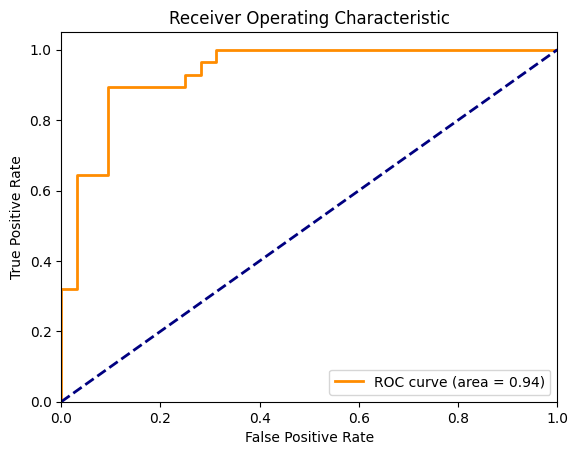

In [5]:
from sklearn.metrics import roc_curve, auc

# 预测概率
y_score = best_model.predict_proba(X_test)[:, 1]

# 计算ROC曲线
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_score)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_logistic:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## 模型保存

In [7]:
import joblib
# 保存模型
joblib.dump(best_model , 'models/XGBoost.pkl')

['models/XGBoost.pkl']